In [2]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 1: IMPORTS + CARREGAR DADOS (SEM GERAR ARQUIVOS)
====================================================
"""

# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ⭐ IMPORTANTE: Mostrar gráficos no notebook
%matplotlib inline

print("=" * 80)
print("ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS")
print("=" * 80)

# ============================================================================
# CARREGAR DADOS DA ETAPA 3
# ============================================================================

print("\n" + "=" * 80)
print("PROCURANDO ARQUIVO CSV...")
print("=" * 80)

import os
from pathlib import Path

projeto_path = Path(r'C:\Users\edu88\Desktop\4-C-Juan-Enoque---students_performance-main')
datasets_path = projeto_path / 'data' / 'datasets'

print(f"\nProcurando em: {datasets_path}")
print(f"Pasta existe? {datasets_path.exists()}")

if datasets_path.exists():
    arquivos_csv = list(datasets_path.glob('*.csv'))
    print(f"\nArquivos CSV encontrados:")
    for arquivo in arquivos_csv:
        print(f"  - {arquivo.name}")
    
    if arquivos_csv:
        DATA_PATH = str(arquivos_csv[0])
        print(f"\n✓ Usando: {DATA_PATH}")
    else:
        print("❌ Nenhum arquivo CSV encontrado!")
        DATA_PATH = None
else:
    print("❌ Pasta não encontrada!")
    DATA_PATH = None

if DATA_PATH:
    print("\nCarregando dados...")
    df = pd.read_csv(DATA_PATH)

    print(f"\n✓ Dados carregados com sucesso!")
    print(f"  Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")

    print(f"\nPrimeiras linhas do dataset:")
    print(df.head(3))

    print(f"\nInformações do dataset:")
    print(df.info())
else:
    print("❌ Não foi possível carregar os dados!")

# ============================================================================
# SEPARAR X E Y
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 2: SEPARAÇÃO DE FEATURES E TARGET")
print("=" * 80)

TARGET_COLUMN = 'final_grade'

print(f"\nIdentificando colunas numéricas...")
colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

if TARGET_COLUMN in colunas_numericas:
    colunas_numericas.remove(TARGET_COLUMN)

print(f"✓ Colunas numéricas encontradas: {len(colunas_numericas)}")
print(f"\nColunas que serão REMOVIDAS (não-numéricas):")
colunas_remover = [col for col in df.columns if col not in colunas_numericas and col != TARGET_COLUMN]
for col in colunas_remover:
    print(f"  - {col} ({df[col].dtype})")

X = df[colunas_numericas].copy()
y = df[TARGET_COLUMN].copy()

print(f"\n✓ Features (X): {X.shape[1]} colunas numéricas")
print(f"✓ Target (y): {y.shape[0]} amostras")

print(f"\nFeatures utilizadas:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# ============================================================================
# TRATAR VALORES FALTANTES
# ============================================================================

print(f"\n" + "-" * 80)
print("VERIFICANDO VALORES FALTANTES")
print("-" * 80)

missing_x = X.isnull().sum()
missing_y = y.isnull().sum()

print(f"\nValores faltantes em X:")
if missing_x.sum() > 0:
    print(missing_x[missing_x > 0])
    print(f"\nTotal de NaN: {missing_x.sum()}")
else:
    print("✓ Sem valores faltantes em X")

if missing_y > 0:
    print(f"\n⚠️  {missing_y} valores faltantes em y")
    indices_validos = ~y.isnull()
    X = X[indices_validos]
    y = y[indices_validos]
    print(f"✓ Removidas {missing_y} linhas com NaN no target")
else:
    print(f"✓ Sem valores faltantes em y")

if missing_x.sum() > 0:
    print(f"\n⚠️  Preenchendo {missing_x.sum()} valores faltantes em X...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
    print(f"✓ Valores faltantes preenchidos com a média")

print(f"\nTarget (final_grade) - Estatísticas:")
print(f"  Média:    {y.mean():.2f}")
print(f"  Mediana:  {y.median():.2f}")
print(f"  Min:      {y.min():.2f}")
print(f"  Max:      {y.max():.2f}")
print(f"  Std Dev:  {y.std():.2f}")

# ============================================================================
# DIVIDIR DADOS
# ============================================================================

print(f"\n" + "-" * 80)
print("DIVIDINDO DADOS (60% Treino / 20% Validação / 20% Teste)")
print("-" * 80)

RANDOM_STATE = 42

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=RANDOM_STATE
)

total_samples = len(X)

print(f"\nTotal de amostras: {total_samples}")
print(f"├─ Treino:     {len(X_train):4d} amostras ({len(X_train)/total_samples*100:.1f}%)")
print(f"├─ Validação:  {len(X_val):4d} amostras ({len(X_val)/total_samples*100:.1f}%)")
print(f"└─ Teste:      {len(X_test):4d} amostras ({len(X_test)/total_samples*100:.1f}%)")

# ============================================================================
# COMBINAR TREINO + VALIDAÇÃO
# ============================================================================

print(f"\n" + "-" * 80)
print("COMBINANDO TREINO + VALIDAÇÃO PARA OTIMIZAÇÃO")
print("-" * 80)

X_train_combined = pd.concat([X_train, X_val], ignore_index=True)
y_train_combined = pd.concat([y_train, y_val], ignore_index=True)

print(f"\n✓ Conjunto combinado para tuning: {len(X_train_combined)} amostras")
print(f"  (Treino {len(X_train)} + Validação {len(X_val)})")

print("\n✅ PARTE 1 CONCLUÍDA!")
print("=" * 80)

ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS

PROCURANDO ARQUIVO CSV...

Procurando em: C:\Users\edu88\Desktop\4-C-Juan-Enoque---students_performance-main\data\datasets
Pasta existe? True

Arquivos CSV encontrados:
  - students_performance.csv
  - students_performance_clean.csv

✓ Usando: C:\Users\edu88\Desktop\4-C-Juan-Enoque---students_performance-main\data\datasets\students_performance.csv

Carregando dados...

✓ Dados carregados com sucesso!
  Dimensões: 2510 linhas × 14 colunas

Primeiras linhas do dataset:
  student_id  age gender parental_education  study_hours_week  \
0   STD01416   22      M           bachelor              5.66   
1   STD01345   19      M           bachelor             13.30   
2   STD01705   25      M             master             10.43   

   attendance_rate extracurricular  sleep_hours  previous_scores tutoring  \
0            69.55             Yes         6.49            49.41       No   
1            58.82             Yes         8.12            50.29

In [3]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 2: MODELOS BASE (SEM GERAR ARQUIVOS)
==========================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 1
"""

# ============================================================================
# PASSO 1: TREINAR MODELOS BASE (SEM TUNING)
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 1: TREINANDO MODELOS BASE (SEM TUNING)")
print("=" * 80)

resultados = {}

# ---- MODELO 1: REGRESSÃO LINEAR ----
print("\n" + "-" * 80)
print("1. REGRESSÃO LINEAR (Baseline)")
print("-" * 80)

modelo_lr = LinearRegression()
modelo_lr.fit(X_train_combined, y_train_combined)

y_val_pred_lr = modelo_lr.predict(X_val)
y_test_pred_lr = modelo_lr.predict(X_test)

r2_val_lr = r2_score(y_val, y_val_pred_lr)
rmse_val_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
mae_val_lr = mean_absolute_error(y_val, y_val_pred_lr)

print(f"\n✓ Regressão Linear Treinada")
print(f"  R² (Validação):   {r2_val_lr:.4f}")
print(f"  RMSE (Validação): {rmse_val_lr:.4f}")
print(f"  MAE (Validação):  {mae_val_lr:.4f}")

resultados['Linear Regression'] = {
    'modelo': modelo_lr,
    'r2_val': r2_val_lr,
    'rmse_val': rmse_val_lr,
    'mae_val': mae_val_lr,
    'y_pred_val': y_val_pred_lr,
    'y_pred_test': y_test_pred_lr,
    'tipo': 'baseline'
}

# ---- MODELO 2: RANDOM FOREST (PADRÃO) ----
print("\n" + "-" * 80)
print("2. RANDOM FOREST (Padrão - Sem Tuning)")
print("-" * 80)

modelo_rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
modelo_rf_base.fit(X_train_combined, y_train_combined)

y_val_pred_rf_base = modelo_rf_base.predict(X_val)
y_test_pred_rf_base = modelo_rf_base.predict(X_test)

r2_val_rf_base = r2_score(y_val, y_val_pred_rf_base)
rmse_val_rf_base = np.sqrt(mean_squared_error(y_val, y_val_pred_rf_base))
mae_val_rf_base = mean_absolute_error(y_val, y_val_pred_rf_base)

print(f"\n✓ Random Forest Base Treinada")
print(f"  R² (Validação):   {r2_val_rf_base:.4f}")
print(f"  RMSE (Validação): {rmse_val_rf_base:.4f}")
print(f"  MAE (Validação):  {mae_val_rf_base:.4f}")

resultados['Random Forest Base'] = {
    'modelo': modelo_rf_base,
    'r2_val': r2_val_rf_base,
    'rmse_val': rmse_val_rf_base,
    'mae_val': mae_val_rf_base,
    'y_pred_val': y_val_pred_rf_base,
    'y_pred_test': y_test_pred_rf_base,
    'tipo': 'base'
}

# ---- MODELO 3: XGBOOST (PADRÃO) ----
print("\n" + "-" * 80)
print("3. XGBOOST (Padrão - Sem Tuning)")
print("-" * 80)

modelo_xgb_base = XGBRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbose=0
)
modelo_xgb_base.fit(X_train_combined, y_train_combined)

y_val_pred_xgb_base = modelo_xgb_base.predict(X_val)
y_test_pred_xgb_base = modelo_xgb_base.predict(X_test)

r2_val_xgb_base = r2_score(y_val, y_val_pred_xgb_base)
rmse_val_xgb_base = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb_base))
mae_val_xgb_base = mean_absolute_error(y_val, y_val_pred_xgb_base)

print(f"\n✓ XGBoost Base Treinada")
print(f"  R² (Validação):   {r2_val_xgb_base:.4f}")
print(f"  RMSE (Validação): {rmse_val_xgb_base:.4f}")
print(f"  MAE (Validação):  {mae_val_xgb_base:.4f}")

resultados['XGBoost Base'] = {
    'modelo': modelo_xgb_base,
    'r2_val': r2_val_xgb_base,
    'rmse_val': rmse_val_xgb_base,
    'mae_val': mae_val_xgb_base,
    'y_pred_val': y_val_pred_xgb_base,
    'y_pred_test': y_test_pred_xgb_base,
    'tipo': 'base'
}

# Tabela Comparativa
print("\n" + "=" * 80)
print("COMPARAÇÃO DOS MODELOS BASE")
print("=" * 80)

tabela_base = pd.DataFrame({
    'Modelo': ['Linear Regression', 'Random Forest Base', 'XGBoost Base'],
    'R² (Val)': [r2_val_lr, r2_val_rf_base, r2_val_xgb_base],
    'RMSE (Val)': [rmse_val_lr, rmse_val_rf_base, rmse_val_xgb_base],
    'MAE (Val)': [mae_val_lr, mae_val_rf_base, mae_val_xgb_base]
})

print(tabela_base.to_string(index=False))

print("\n✅ PARTE 2 CONCLUÍDA!")
print("=" * 80)


PASSO 1: TREINANDO MODELOS BASE (SEM TUNING)

--------------------------------------------------------------------------------
1. REGRESSÃO LINEAR (Baseline)
--------------------------------------------------------------------------------

✓ Regressão Linear Treinada
  R² (Validação):   0.2826
  RMSE (Validação): 6.3706
  MAE (Validação):  5.1558

--------------------------------------------------------------------------------
2. RANDOM FOREST (Padrão - Sem Tuning)
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished



✓ Random Forest Base Treinada
  R² (Validação):   0.9341
  RMSE (Validação): 1.9305
  MAE (Validação):  1.4744

--------------------------------------------------------------------------------
3. XGBOOST (Padrão - Sem Tuning)
--------------------------------------------------------------------------------

✓ XGBoost Base Treinada
  R² (Validação):   0.9625
  RMSE (Validação): 1.4566
  MAE (Validação):  0.9922

COMPARAÇÃO DOS MODELOS BASE
            Modelo  R² (Val)  RMSE (Val)  MAE (Val)
 Linear Regression  0.282618    6.370594   5.155791
Random Forest Base  0.934125    1.930483   1.474432
      XGBoost Base  0.962496    1.456614   0.992244

✅ PARTE 2 CONCLUÍDA!


In [4]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 3: RANDOM SEARCH PARA RANDOM FOREST (SEM GERAR ARQUIVOS)
============================================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 2
"""

# ============================================================================
# PASSO 2: RANDOM SEARCH PARA RANDOM FOREST
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 2: RANDOM SEARCH PARA RANDOM FOREST")
print("=" * 80)

print("\nExecutando Random Search com 50 iterações...")
print("(Isso pode demorar alguns minutos...)\n")

param_dist_rf = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=RANDOM_STATE,
    verbose=1,
    n_jobs=-1
)

random_search_rf.fit(X_train_combined, y_train_combined)

print("\n" + "=" * 80)
print("RESULTADOS DO RANDOM SEARCH - RANDOM FOREST")
print("=" * 80)

print(f"\n✓ Melhor R² encontrado: {random_search_rf.best_score_:.4f}")
print(f"\nMelhores Hiperparâmetros:")
for param, valor in random_search_rf.best_params_.items():
    print(f"  {param}: {valor}")

melhor_modelo_rf = random_search_rf.best_estimator_

y_val_pred_rf_tuned = melhor_modelo_rf.predict(X_val)
y_test_pred_rf_tuned = melhor_modelo_rf.predict(X_test)

r2_val_rf_tuned = r2_score(y_val, y_val_pred_rf_tuned)
rmse_val_rf_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_rf_tuned))
mae_val_rf_tuned = mean_absolute_error(y_val, y_val_pred_rf_tuned)

print(f"\n" + "-" * 80)
print("PERFORMANCE DO MODELO OTIMIZADO (VALIDAÇÃO)")
print("-" * 80)
print(f"R² (Validação):   {r2_val_rf_tuned:.4f}")
print(f"RMSE (Validação): {rmse_val_rf_tuned:.4f}")
print(f"MAE (Validação):  {mae_val_rf_tuned:.4f}")

print(f"\n" + "-" * 80)
print("COMPARAÇÃO: RANDOM FOREST BASE vs OTIMIZADO")
print("-" * 80)

melhoria_r2 = r2_val_rf_tuned - r2_val_rf_base
melhoria_rmse = rmse_val_rf_base - rmse_val_rf_tuned
melhoria_mae = mae_val_rf_base - mae_val_rf_tuned

print(f"\nR² (Validação):")
print(f"  Antes:     {r2_val_rf_base:.4f}")
print(f"  Depois:    {r2_val_rf_tuned:.4f}")
print(f"  Melhoria:  {melhoria_r2:+.4f} ({(melhoria_r2/r2_val_rf_base)*100:+.2f}%)")

print(f"\nRMSE (Validação):")
print(f"  Antes:     {rmse_val_rf_base:.4f}")
print(f"  Depois:    {rmse_val_rf_tuned:.4f}")
print(f"  Melhoria:  {melhoria_rmse:+.4f} ({(melhoria_rmse/rmse_val_rf_base)*100:+.2f}%)")

print(f"\nMAE (Validação):")
print(f"  Antes:     {mae_val_rf_base:.4f}")
print(f"  Depois:    {mae_val_rf_tuned:.4f}")
print(f"  Melhoria:  {melhoria_mae:+.4f} ({(melhoria_mae/mae_val_rf_base)*100:+.2f}%)")

resultados['Random Forest Otimizado'] = {
    'modelo': melhor_modelo_rf,
    'r2_val': r2_val_rf_tuned,
    'rmse_val': rmse_val_rf_tuned,
    'mae_val': mae_val_rf_tuned,
    'y_pred_val': y_val_pred_rf_tuned,
    'y_pred_test': y_test_pred_rf_tuned,
    'tipo': 'otimizado',
    'best_params': random_search_rf.best_params_,
    'cv_score': random_search_rf.best_score_
}

print("\n✅ PARTE 3 CONCLUÍDA!")
print("=" * 80)


PASSO 2: RANDOM SEARCH PARA RANDOM FOREST

Executando Random Search com 50 iterações...
(Isso pode demorar alguns minutos...)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

RESULTADOS DO RANDOM SEARCH - RANDOM FOREST

✓ Melhor R² encontrado: 0.5187

Melhores Hiperparâmetros:
  n_estimators: 200
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: 10
  bootstrap: True

--------------------------------------------------------------------------------
PERFORMANCE DO MODELO OTIMIZADO (VALIDAÇÃO)
--------------------------------------------------------------------------------
R² (Validação):   0.7772
RMSE (Validação): 3.5503
MAE (Validação):  2.7464

--------------------------------------------------------------------------------
COMPARAÇÃO: RANDOM FOREST BASE vs OTIMIZADO
--------------------------------------------------------------------------------

R² (Validação):
  Antes:     0.9341
  Depois:    0.7772
  Melhoria:  -0.1569 (-16.80%)

RMSE (Va

In [5]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 4: RANDOM SEARCH PARA XGBOOST (SEM GERAR ARQUIVOS)
======================================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 3
"""

# ============================================================================
# PASSO 3: RANDOM SEARCH PARA XGBOOST
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 3: RANDOM SEARCH PARA XGBOOST")
print("=" * 80)

print("\nExecutando Random Search com 50 iterações...")
print("(Isso pode demorar alguns minutos...)\n")

param_dist_xgb = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 2],
    'min_child_weight': [1, 2, 3, 4, 5]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=RANDOM_STATE,
    verbose=1,
    n_jobs=-1
)

random_search_xgb.fit(X_train_combined, y_train_combined)

print("\n" + "=" * 80)
print("RESULTADOS DO RANDOM SEARCH - XGBOOST")
print("=" * 80)

print(f"\n✓ Melhor R² encontrado: {random_search_xgb.best_score_:.4f}")
print(f"\nMelhores Hiperparâmetros:")
for param, valor in random_search_xgb.best_params_.items():
    print(f"  {param}: {valor}")

melhor_modelo_xgb = random_search_xgb.best_estimator_

y_val_pred_xgb_tuned = melhor_modelo_xgb.predict(X_val)
y_test_pred_xgb_tuned = melhor_modelo_xgb.predict(X_test)

r2_val_xgb_tuned = r2_score(y_val, y_val_pred_xgb_tuned)
rmse_val_xgb_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb_tuned))
mae_val_xgb_tuned = mean_absolute_error(y_val, y_val_pred_xgb_tuned)

print(f"\n" + "-" * 80)
print("PERFORMANCE DO MODELO OTIMIZADO (VALIDAÇÃO)")
print("-" * 80)
print(f"R² (Validação):   {r2_val_xgb_tuned:.4f}")
print(f"RMSE (Validação): {rmse_val_xgb_tuned:.4f}")
print(f"MAE (Validação):  {mae_val_xgb_tuned:.4f}")

print(f"\n" + "-" * 80)
print("COMPARAÇÃO: XGBOOST BASE vs OTIMIZADO")
print("-" * 80)

melhoria_r2_xgb = r2_val_xgb_tuned - r2_val_xgb_base
melhoria_rmse_xgb = rmse_val_xgb_base - rmse_val_xgb_tuned
melhoria_mae_xgb = mae_val_xgb_base - mae_val_xgb_tuned

print(f"\nR² (Validação):")
print(f"  Antes:     {r2_val_xgb_base:.4f}")
print(f"  Depois:    {r2_val_xgb_tuned:.4f}")
print(f"  Melhoria:  {melhoria_r2_xgb:+.4f} ({(melhoria_r2_xgb/r2_val_xgb_base)*100:+.2f}%)")

print(f"\nRMSE (Validação):")
print(f"  Antes:     {rmse_val_xgb_base:.4f}")
print(f"  Depois:    {rmse_val_xgb_tuned:.4f}")
print(f"  Melhoria:  {melhoria_rmse_xgb:+.4f} ({(melhoria_rmse_xgb/rmse_val_xgb_base)*100:+.2f}%)")

print(f"\nMAE (Validação):")
print(f"  Antes:     {mae_val_xgb_base:.4f}")
print(f"  Depois:    {mae_val_xgb_tuned:.4f}")
print(f"  Melhoria:  {melhoria_mae_xgb:+.4f} ({(melhoria_mae_xgb/mae_val_xgb_base)*100:+.2f}%)")

resultados['XGBoost Otimizado'] = {
    'modelo': melhor_modelo_xgb,
    'r2_val': r2_val_xgb_tuned,
    'rmse_val': rmse_val_xgb_tuned,
    'mae_val': mae_val_xgb_tuned,
    'y_pred_val': y_val_pred_xgb_tuned,
    'y_pred_test': y_test_pred_xgb_tuned,
    'tipo': 'otimizado',
    'best_params': random_search_xgb.best_params_,
    'cv_score': random_search_xgb.best_score_
}

print("\n✅ PARTE 4 CONCLUÍDA!")
print("=" * 80)


PASSO 3: RANDOM SEARCH PARA XGBOOST

Executando Random Search com 50 iterações...
(Isso pode demorar alguns minutos...)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

RESULTADOS DO RANDOM SEARCH - XGBOOST

✓ Melhor R² encontrado: 0.5277

Melhores Hiperparâmetros:
  subsample: 0.8
  n_estimators: 50
  min_child_weight: 3
  max_depth: 3
  learning_rate: 0.1
  gamma: 0
  colsample_bytree: 1.0

--------------------------------------------------------------------------------
PERFORMANCE DO MODELO OTIMIZADO (VALIDAÇÃO)
--------------------------------------------------------------------------------
R² (Validação):   0.5841
RMSE (Validação): 4.8507
MAE (Validação):  3.7426

--------------------------------------------------------------------------------
COMPARAÇÃO: XGBOOST BASE vs OTIMIZADO
--------------------------------------------------------------------------------

R² (Validação):
  Antes:     0.9625
  Depois:    0.5841
  Melhoria:  -0.3784 (-39.31%)

RMSE (Validação):


PASSO 4: COMPARAÇÃO DOS 5 MODELOS

RANKING DE MODELOS (VALIDAÇÃO)
                 Modelo  R² (Val)  RMSE (Val)  MAE (Val)
           XGBoost Base  0.962496    1.456614   0.992244
     Random Forest Base  0.934125    1.930483   1.474432
Random Forest Otimizado  0.777203    3.550256   2.746369
      XGBoost Otimizado  0.584091    4.850695   3.742617
      Linear Regression  0.282618    6.370594   5.155791

🏆 MELHOR MODELO: XGBoost Base
  R² (Validação):   0.9625
  RMSE (Validação): 1.4566
  MAE (Validação):  0.9922

--------------------------------------------------------------------------------
MELHORIA EM RELAÇÃO AO BASELINE (LINEAR REGRESSION)
--------------------------------------------------------------------------------
R² do Baseline:    0.2826
R² do Melhor:      0.9625
Melhoria:          +240.56%


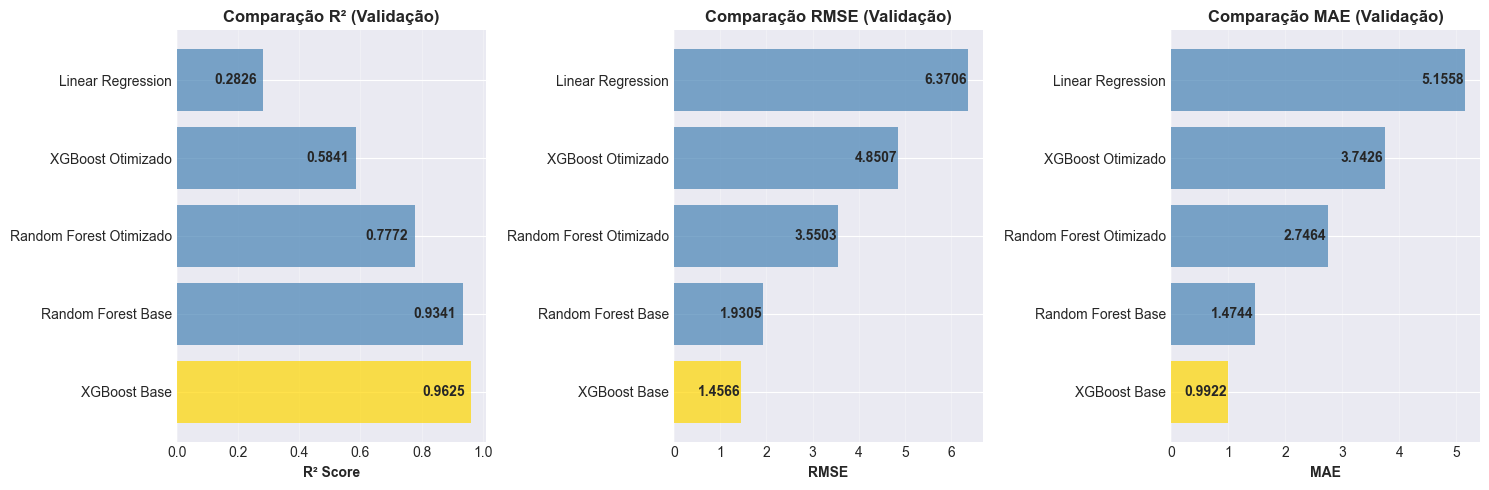


✅ PARTE 5 CONCLUÍDA!


In [6]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 5: COMPARAÇÃO DOS 5 MODELOS (GRÁFICOS NO NOTEBOOK)
======================================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 4
"""

# ============================================================================
# PASSO 4: COMPARAÇÃO DOS 5 MODELOS
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 4: COMPARAÇÃO DOS 5 MODELOS")
print("=" * 80)

# Criar tabela comparativa
tabela_comparativa = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'R² (Val)': [resultados[m]['r2_val'] for m in resultados.keys()],
    'RMSE (Val)': [resultados[m]['rmse_val'] for m in resultados.keys()],
    'MAE (Val)': [resultados[m]['mae_val'] for m in resultados.keys()]
})

tabela_comparativa = tabela_comparativa.sort_values('R² (Val)', ascending=False)

print("\n" + "=" * 80)
print("RANKING DE MODELOS (VALIDAÇÃO)")
print("=" * 80)
print(tabela_comparativa.to_string(index=False))

# Melhor modelo
melhor_nome = tabela_comparativa.iloc[0]['Modelo']
melhor_r2 = tabela_comparativa.iloc[0]['R² (Val)']
melhor_rmse = tabela_comparativa.iloc[0]['RMSE (Val)']
melhor_mae = tabela_comparativa.iloc[0]['MAE (Val)']

print(f"\n" + "=" * 80)
print(f"🏆 MELHOR MODELO: {melhor_nome}")
print("=" * 80)
print(f"  R² (Validação):   {melhor_r2:.4f}")
print(f"  RMSE (Validação): {melhor_rmse:.4f}")
print(f"  MAE (Validação):  {melhor_mae:.4f}")

# Comparação com baseline
baseline_r2 = resultados['Linear Regression']['r2_val']
melhoria_em_r2 = ((melhor_r2 - baseline_r2) / baseline_r2) * 100

print(f"\n" + "-" * 80)
print("MELHORIA EM RELAÇÃO AO BASELINE (LINEAR REGRESSION)")
print("-" * 80)
print(f"R² do Baseline:    {baseline_r2:.4f}")
print(f"R² do Melhor:      {melhor_r2:.4f}")
print(f"Melhoria:          {melhoria_em_r2:+.2f}%")

# Gráfico Comparativo (SEM SALVAR)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R²
ax1 = axes[0]
cores_r2 = ['gold' if x == tabela_comparativa.iloc[0]['Modelo'] else 'steelblue' 
            for x in tabela_comparativa['Modelo']]
ax1.barh(tabela_comparativa['Modelo'], tabela_comparativa['R² (Val)'], color=cores_r2, alpha=0.7)
ax1.set_xlabel('R² Score', fontweight='bold')
ax1.set_title('Comparação R² (Validação)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(tabela_comparativa['R² (Val)']):
    ax1.text(v - 0.02, i, f'{v:.4f}', va='center', ha='right', fontweight='bold')

# RMSE
ax2 = axes[1]
cores_rmse = ['gold' if x == tabela_comparativa.iloc[0]['Modelo'] else 'steelblue' 
              for x in tabela_comparativa['Modelo']]
ax2.barh(tabela_comparativa['Modelo'], tabela_comparativa['RMSE (Val)'], color=cores_rmse, alpha=0.7)
ax2.set_xlabel('RMSE', fontweight='bold')
ax2.set_title('Comparação RMSE (Validação)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(tabela_comparativa['RMSE (Val)']):
    ax2.text(v - 0.02, i, f'{v:.4f}', va='center', ha='right', fontweight='bold')

# MAE
ax3 = axes[2]
cores_mae = ['gold' if x == tabela_comparativa.iloc[0]['Modelo'] else 'steelblue' 
             for x in tabela_comparativa['Modelo']]
ax3.barh(tabela_comparativa['Modelo'], tabela_comparativa['MAE (Val)'], color=cores_mae, alpha=0.7)
ax3.set_xlabel('MAE', fontweight='bold')
ax3.set_title('Comparação MAE (Validação)', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(tabela_comparativa['MAE (Val)']):
    ax3.text(v - 0.02, i, f'{v:.4f}', va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ PARTE 5 CONCLUÍDA!")
print("=" * 80)


PASSO 5: AVALIAÇÃO NO CONJUNTO DE TESTE

⚠️  ATENÇÃO: Avaliação final no conjunto de TESTE (usado apenas uma vez!)

RESULTADOS NO CONJUNTO DE TESTE
                 Modelo  R² (Test)  RMSE (Test)  MAE (Test)  R² (Val)  RMSE (Val)
      XGBoost Otimizado   0.517797     4.927443    3.798959  0.584091    4.850695
Random Forest Otimizado   0.506360     4.985537    3.888656  0.777203    3.550256
     Random Forest Base   0.471076     5.160638    3.925537  0.934125    1.930483
           XGBoost Base   0.390604     5.539320    4.248027  0.962496    1.456614
      Linear Regression   0.189787     6.387136    5.175437  0.282618    6.370594

--------------------------------------------------------------------------------
ANÁLISE DE OVERFITTING (Val vs Test)
--------------------------------------------------------------------------------

XGBoost Otimizado:
  R² Val:        0.5841
  R² Test:       0.5178
  Diferença:     0.0663  ⚠️  Possível overfitting

Random Forest Otimizado:
  R² Val:      

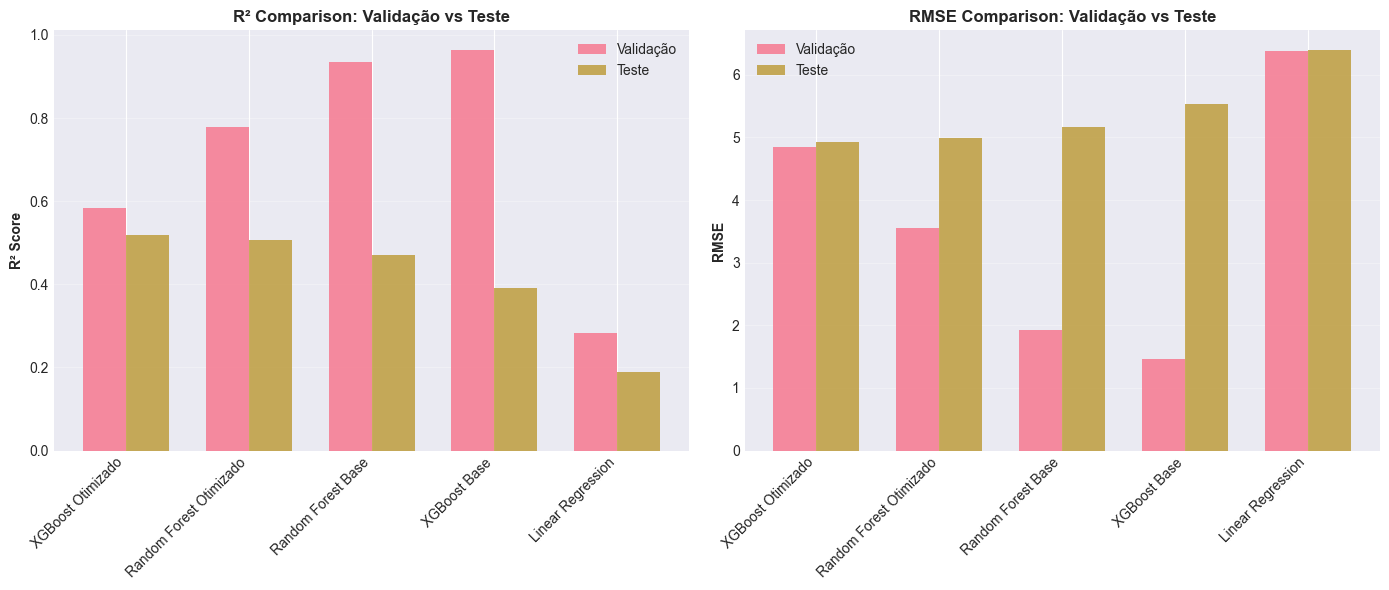


✅ PARTE 6 CONCLUÍDA!


In [7]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 6: AVALIAÇÃO NO CONJUNTO DE TESTE (GRÁFICOS NO NOTEBOOK)
============================================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 5
⚠️ Conjunto de teste é usado APENAS aqui, uma única vez!
"""

# ============================================================================
# PASSO 5: AVALIAÇÃO NO CONJUNTO DE TESTE
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 5: AVALIAÇÃO NO CONJUNTO DE TESTE")
print("=" * 80)
print("\n⚠️  ATENÇÃO: Avaliação final no conjunto de TESTE (usado apenas uma vez!)")

# Calcular métricas para todos os modelos no TESTE
tabela_teste = []

for nome_modelo, dados_modelo in resultados.items():
    y_pred_test = dados_modelo['y_pred_test']
    
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    tabela_teste.append({
        'Modelo': nome_modelo,
        'R² (Test)': r2_test,
        'RMSE (Test)': rmse_test,
        'MAE (Test)': mae_test,
        'R² (Val)': dados_modelo['r2_val'],
        'RMSE (Val)': dados_modelo['rmse_val']
    })
    
    dados_modelo['r2_test'] = r2_test
    dados_modelo['rmse_test'] = rmse_test
    dados_modelo['mae_test'] = mae_test

tabela_teste_df = pd.DataFrame(tabela_teste).sort_values('R² (Test)', ascending=False)

print("\n" + "=" * 80)
print("RESULTADOS NO CONJUNTO DE TESTE")
print("=" * 80)
print(tabela_teste_df.to_string(index=False))

# Análise de overfitting
print(f"\n" + "-" * 80)
print("ANÁLISE DE OVERFITTING (Val vs Test)")
print("-" * 80)

for idx, row in tabela_teste_df.iterrows():
    nome = row['Modelo']
    diff_r2 = abs(row['R² (Val)'] - row['R² (Test)'])
    status = "✅ Sem overfitting" if diff_r2 < 0.05 else "⚠️  Possível overfitting" if diff_r2 < 0.15 else "❌ Overfitting significativo"
    print(f"\n{nome}:")
    print(f"  R² Val:        {row['R² (Val)']:.4f}")
    print(f"  R² Test:       {row['R² (Test)']:.4f}")
    print(f"  Diferença:     {diff_r2:.4f}  {status}")

# Melhor modelo no TESTE
melhor_nome_teste = tabela_teste_df.iloc[0]['Modelo']
melhor_r2_teste = tabela_teste_df.iloc[0]['R² (Test)']
melhor_rmse_teste = tabela_teste_df.iloc[0]['RMSE (Test)']
melhor_mae_teste = tabela_teste_df.iloc[0]['MAE (Test)']

print(f"\n" + "=" * 80)
print(f"🏆 MELHOR MODELO (TESTE): {melhor_nome_teste}")
print("=" * 80)
print(f"  R² (Teste):   {melhor_r2_teste:.4f}")
print(f"  RMSE (Teste): {melhor_rmse_teste:.4f}")
print(f"  MAE (Teste):  {melhor_mae_teste:.4f}")

# Gráfico: Validação vs Teste (SEM SALVAR)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² Comparison
ax1 = axes[0]
x = np.arange(len(tabela_teste_df))
width = 0.35
ax1.bar(x - width/2, tabela_teste_df['R² (Val)'], width, label='Validação', alpha=0.8)
ax1.bar(x + width/2, tabela_teste_df['R² (Test)'], width, label='Teste', alpha=0.8)
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('R² Comparison: Validação vs Teste', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(tabela_teste_df['Modelo'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# RMSE Comparison
ax2 = axes[1]
ax2.bar(x - width/2, tabela_teste_df['RMSE (Val)'], width, label='Validação', alpha=0.8)
ax2.bar(x + width/2, tabela_teste_df['RMSE (Test)'], width, label='Teste', alpha=0.8)
ax2.set_ylabel('RMSE', fontweight='bold')
ax2.set_title('RMSE Comparison: Validação vs Teste', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(tabela_teste_df['Modelo'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Armazenar referência do melhor modelo
melhor_modelo = resultados[melhor_nome_teste]['modelo']

print("\n✅ PARTE 6 CONCLUÍDA!")
print("=" * 80)


PASSO 6: ANÁLISE DE ERROS DETALHADA

Analisando erros do modelo: XGBoost Otimizado

--------------------------------------------------------------------------------
ESTATÍSTICAS DOS RESÍDUOS (TESTE)
--------------------------------------------------------------------------------

Média dos resíduos:     +0.2641
Mediana dos resíduos:   +0.9632
Desvio padrão:          4.9253
Min:                    -21.2866
Max:                    +16.5245
Percentil 25:           -2.5912
Percentil 75:           +3.1412

--------------------------------------------------------------------------------
TOP 10 PIORES PREVISÕES (MAIOR ERRO ABSOLUTO)
--------------------------------------------------------------------------------
 Índice  Valor Real  Valor Previsto       Erro  Erro Absoluto
     81       72.05       93.336571 -21.286571      21.286571
    142       97.21       80.685501  16.524499      16.524499
     42       76.38       91.246796 -14.866796      14.866796
    109       77.50       91.905678 

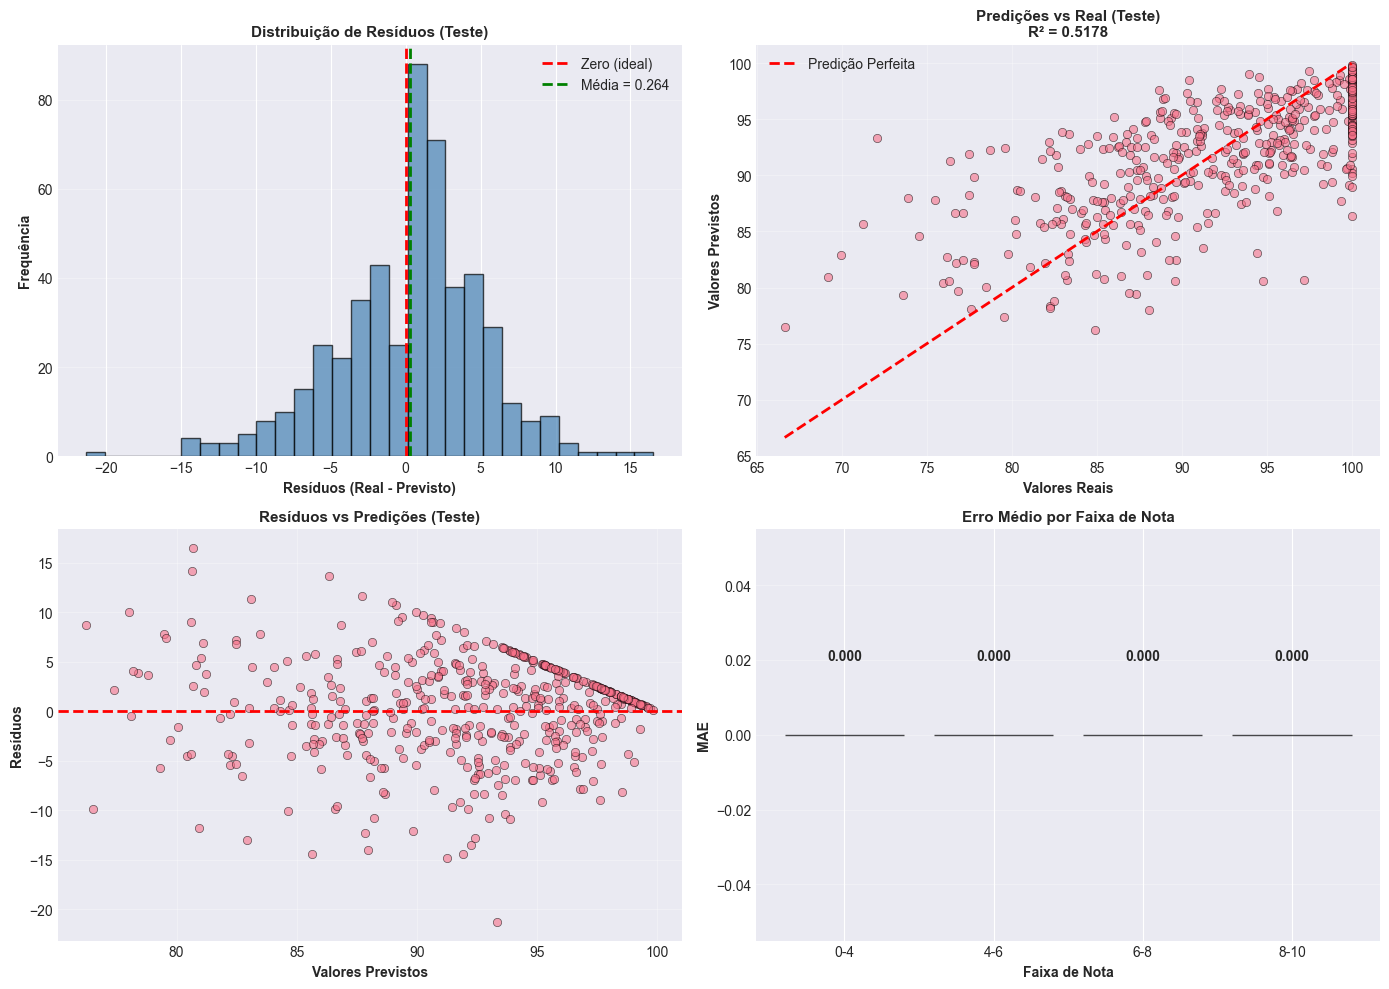


✅ PARTE 7 CONCLUÍDA!


In [8]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 7: ANÁLISE DE ERROS DETALHADA (GRÁFICOS NO NOTEBOOK)
========================================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 6
"""

# ============================================================================
# PASSO 6: ANÁLISE DE ERROS DETALHADA
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 6: ANÁLISE DE ERROS DETALHADA")
print("=" * 80)

# Usar o melhor modelo (no teste)
y_pred_best = resultados[melhor_nome_teste]['y_pred_test']
residuos_best = y_test - y_pred_best

print(f"\nAnalisando erros do modelo: {melhor_nome_teste}")

# Estatísticas dos resíduos
print(f"\n" + "-" * 80)
print("ESTATÍSTICAS DOS RESÍDUOS (TESTE)")
print("-" * 80)

print(f"\nMédia dos resíduos:     {residuos_best.mean():+.4f}")
print(f"Mediana dos resíduos:   {residuos_best.median():+.4f}")
print(f"Desvio padrão:          {residuos_best.std():.4f}")
print(f"Min:                    {residuos_best.min():+.4f}")
print(f"Max:                    {residuos_best.max():+.4f}")
print(f"Percentil 25:           {residuos_best.quantile(0.25):+.4f}")
print(f"Percentil 75:           {residuos_best.quantile(0.75):+.4f}")

# Erros maiores (top 10 piores previsões)
print(f"\n" + "-" * 80)
print("TOP 10 PIORES PREVISÕES (MAIOR ERRO ABSOLUTO)")
print("-" * 80)

erros_abs = np.abs(residuos_best)
top_10_indices = np.argsort(erros_abs)[-10:][::-1]

top_10_df = pd.DataFrame({
    'Índice': top_10_indices,
    'Valor Real': y_test.iloc[top_10_indices].values,
    'Valor Previsto': y_pred_best[top_10_indices],
    'Erro': residuos_best.iloc[top_10_indices].values,
    'Erro Absoluto': erros_abs.iloc[top_10_indices].values
})

print(top_10_df.to_string(index=False))

# Distribuição de erros por faixa de nota
print(f"\n" + "-" * 80)
print("DISTRIBUIÇÃO DE ERROS POR FAIXA DE NOTA")
print("-" * 80)

faixas = [(0, 4), (4, 6), (6, 8), (8, 10)]
faixa_labels = ['0-4 (Crítico)', '4-6 (Baixo)', '6-8 (Médio)', '8-10 (Alto)']

for (inicio, fim), label in zip(faixas, faixa_labels):
    mask = (y_test >= inicio) & (y_test < fim)
    if mask.sum() > 0:
        rmse_faixa = np.sqrt(mean_squared_error(y_test[mask], y_pred_best[mask]))
        mae_faixa = mean_absolute_error(y_test[mask], y_pred_best[mask])
        r2_faixa = r2_score(y_test[mask], y_pred_best[mask])
        count = mask.sum()
        
        print(f"\n{label} ({count} amostras):")
        print(f"  RMSE: {rmse_faixa:.4f}")
        print(f"  MAE:  {mae_faixa:.4f}")
        print(f"  R²:   {r2_faixa:.4f}")

# Gráficos de análise de erros (SEM SALVAR)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribuição de Resíduos
ax1 = axes[0, 0]
ax1.hist(residuos_best, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (ideal)')
ax1.axvline(residuos_best.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Média = {residuos_best.mean():.3f}')
ax1.set_xlabel('Resíduos (Real - Previsto)', fontweight='bold')
ax1.set_ylabel('Frequência', fontweight='bold')
ax1.set_title('Distribuição de Resíduos (Teste)', fontweight='bold', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Predições vs Real
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred_best, alpha=0.6, edgecolors='k', linewidth=0.5)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predição Perfeita')
ax2.set_xlabel('Valores Reais', fontweight='bold')
ax2.set_ylabel('Valores Previstos', fontweight='bold')
ax2.set_title(f'Predições vs Real (Teste)\nR² = {melhor_r2_teste:.4f}', fontweight='bold', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Resíduos vs Predições
ax3 = axes[1, 0]
ax3.scatter(y_pred_best, residuos_best, alpha=0.6, edgecolors='k', linewidth=0.5)
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Valores Previstos', fontweight='bold')
ax3.set_ylabel('Resíduos', fontweight='bold')
ax3.set_title('Resíduos vs Predições (Teste)', fontweight='bold', fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Erro Absoluto por Faixa
ax4 = axes[1, 1]
faixas_labels_curtas = ['0-4', '4-6', '6-8', '8-10']
mae_por_faixa = []
for (inicio, fim) in faixas:
    mask = (y_test >= inicio) & (y_test < fim)
    if mask.sum() > 0:
        mae_faixa = mean_absolute_error(y_test[mask], y_pred_best[mask])
        mae_por_faixa.append(mae_faixa)
    else:
        mae_por_faixa.append(0)

cores_faixa = ['red' if x > 0.5 else 'orange' if x > 0.3 else 'green' for x in mae_por_faixa]
ax4.bar(faixas_labels_curtas, mae_por_faixa, color=cores_faixa, alpha=0.7, edgecolor='black')
ax4.set_ylabel('MAE', fontweight='bold')
ax4.set_xlabel('Faixa de Nota', fontweight='bold')
ax4.set_title('Erro Médio por Faixa de Nota', fontweight='bold', fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_por_faixa):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ PARTE 7 CONCLUÍDA!")
print("=" * 80)


PASSO 7: CRIANDO GRÁFICOS COMPARATIVOS FINAIS


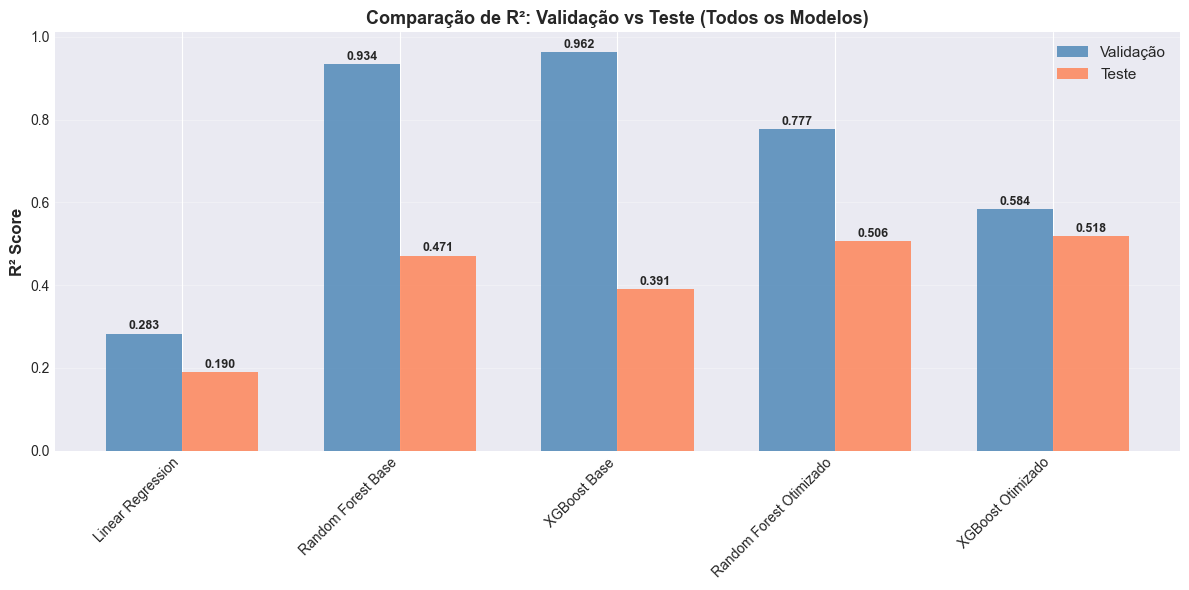

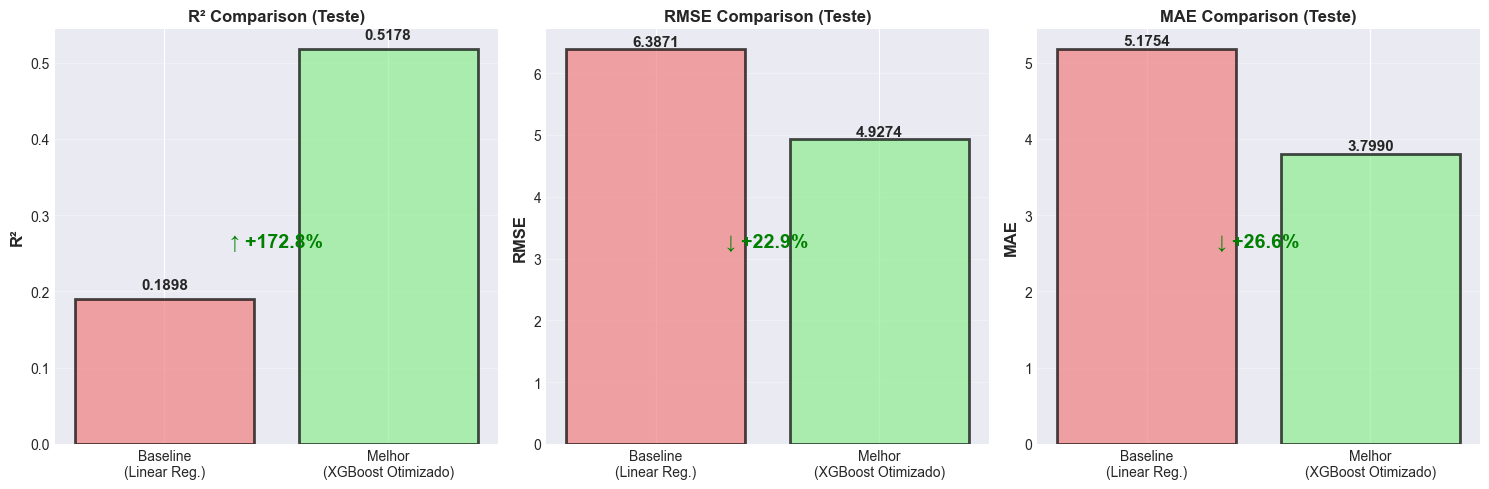

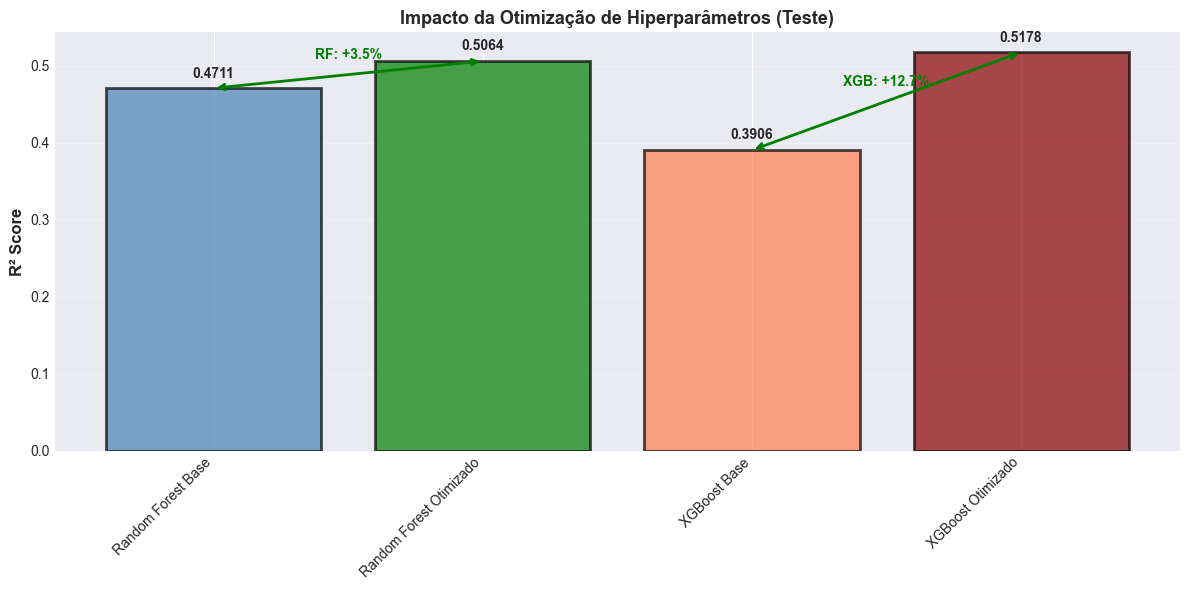


✅ PARTE 8 CONCLUÍDA!


In [9]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 8: GRÁFICOS COMPARATIVOS FINAIS (SEM SALVAR)
================================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 7
"""

# ============================================================================
# PASSO 7: GRÁFICOS COMPARATIVOS FINAIS
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 7: CRIANDO GRÁFICOS COMPARATIVOS FINAIS")
print("=" * 80)

# ---- GRÁFICO 1: EVOLUÇÃO DOS MODELOS ----
fig, ax = plt.subplots(figsize=(12, 6))

modelos = list(resultados.keys())
r2_val = [resultados[m]['r2_val'] for m in modelos]
r2_test = [resultados[m]['r2_test'] for m in modelos]

x = np.arange(len(modelos))
width = 0.35

ax.bar(x - width/2, r2_val, width, label='Validação', alpha=0.8, color='steelblue')
ax.bar(x + width/2, r2_test, width, label='Teste', alpha=0.8, color='coral')

ax.set_ylabel('R² Score', fontweight='bold', fontsize=12)
ax.set_title('Comparação de R²: Validação vs Teste (Todos os Modelos)', 
             fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

for i, (v, t) in enumerate(zip(r2_val, r2_test)):
    ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width/2, t + 0.01, f'{t:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ---- GRÁFICO 2: BASELINE vs MELHOR MODELO ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['R²', 'RMSE', 'MAE']
baseline_vals = [
    resultados['Linear Regression']['r2_test'],
    resultados['Linear Regression']['rmse_test'],
    resultados['Linear Regression']['mae_test']
]
best_vals = [
    resultados[melhor_nome_teste]['r2_test'],
    resultados[melhor_nome_teste]['rmse_test'],
    resultados[melhor_nome_teste]['mae_test']
]

for i, (ax, metric, baseline, best) in enumerate(zip(axes, metrics, baseline_vals, best_vals)):
    x_pos = [0, 1]
    valores = [baseline, best]
    cores = ['lightcoral', 'lightgreen']
    
    bars = ax.bar(x_pos, valores, color=cores, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Baseline\n(Linear Reg.)', f'Melhor\n({melhor_nome_teste})'])
    ax.set_ylabel(metric, fontweight='bold', fontsize=12)
    ax.set_title(f'{metric} Comparison (Teste)', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    for j, (bar, val) in enumerate(zip(bars, valores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    if i == 0:
        melhoria = ((best - baseline) / abs(baseline)) * 100
        cor_seta = 'green' if melhoria > 0 else 'red'
        ax.text(0.5, max(valores) * 0.5, f'↑ {melhoria:+.1f}%', 
                ha='center', fontsize=14, fontweight='bold', color=cor_seta)
    elif i > 0:
        melhoria = ((baseline - best) / baseline) * 100
        cor_seta = 'green' if melhoria > 0 else 'red'
        ax.text(0.5, max(valores) * 0.5, f'↓ {melhoria:+.1f}%', 
                ha='center', fontsize=14, fontweight='bold', color=cor_seta)

plt.tight_layout()
plt.show()

# ---- GRÁFICO 3: MELHORIA PÓS-OTIMIZAÇÃO ----
fig, ax = plt.subplots(figsize=(12, 6))

modelos_otimizados = ['Random Forest Base', 'Random Forest Otimizado', 
                      'XGBoost Base', 'XGBoost Otimizado']
r2_vals_otim = [resultados[m]['r2_test'] for m in modelos_otimizados]

x_pos = np.arange(0, len(modelos_otimizados), 1)
cores_otim = ['steelblue', 'green', 'coral', 'darkred']

bars = ax.bar(x_pos, r2_vals_otim, color=cores_otim, alpha=0.7, edgecolor='black', linewidth=2)

ax.set_ylabel('R² Score', fontweight='bold', fontsize=12)
ax.set_title('Impacto da Otimização de Hiperparâmetros (Teste)', 
             fontweight='bold', fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(modelos_otimizados, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, r2_vals_otim):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# Setas de melhoria
ax.annotate('', xy=(1, r2_vals_otim[1]), xytext=(0, r2_vals_otim[0]),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(0.5, (r2_vals_otim[0] + r2_vals_otim[1])/2 + 0.02, 
        f'RF: {(r2_vals_otim[1]-r2_vals_otim[0])*100:+.1f}%', 
        ha='center', fontsize=10, fontweight='bold', color='green')

ax.annotate('', xy=(3, r2_vals_otim[3]), xytext=(2, r2_vals_otim[2]),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(2.5, (r2_vals_otim[2] + r2_vals_otim[3])/2 + 0.02, 
        f'XGB: {(r2_vals_otim[3]-r2_vals_otim[2])*100:+.1f}%', 
        ha='center', fontsize=10, fontweight='bold', color='green')

plt.tight_layout()
plt.show()

print("\n✅ PARTE 8 CONCLUÍDA!")
print("=" * 80)

In [10]:
"""
ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
PARTE 9: RESUMO FINAL + SALVAR MODELO
====================================

⚠️ IMPORTANTE: Cole APÓS a PARTE 8
"""

# ============================================================================
# PASSO 8: SALVAR MODELO FINAL
# ============================================================================

print("\n" + "=" * 80)
print("PASSO 8: SALVANDO MODELO FINAL")
print("=" * 80)

# Salvar o melhor modelo
modelo_final_path = 'modelo_final.pkl'
joblib.dump(melhor_modelo, modelo_final_path)
print(f"\n✓ Modelo final salvo: {modelo_final_path}")

# Salvar informações do modelo final
info_modelo_final = {
    'nome': melhor_nome_teste,
    'r2_validacao': resultados[melhor_nome_teste]['r2_val'],
    'rmse_validacao': resultados[melhor_nome_teste]['rmse_val'],
    'mae_validacao': resultados[melhor_nome_teste]['mae_val'],
    'r2_teste': resultados[melhor_nome_teste]['r2_test'],
    'rmse_teste': resultados[melhor_nome_teste]['rmse_test'],
    'mae_teste': resultados[melhor_nome_teste]['mae_test']
}

if 'best_params' in resultados[melhor_nome_teste]:
    info_modelo_final['best_params'] = resultados[melhor_nome_teste]['best_params']
    info_modelo_final['cv_score'] = resultados[melhor_nome_teste]['cv_score']

import json
with open('info_modelo_final.json', 'w') as f:
    json.dump(info_modelo_final, f, indent=4, default=str)
print(f"✓ Informações do modelo salvas: info_modelo_final.json")

# Salvar tabela comparativa final
tabela_teste_df.to_csv('resultados_finais.csv', index=False)
print(f"✓ Resultados finais salvos: resultados_finais.csv")

# ============================================================================
# PASSO 9: RESUMO FINAL DETALHADO
# ============================================================================

print("\n" + "=" * 80)
print("RESUMO FINAL - ETAPA 4 CONCLUÍDA")
print("=" * 80)

print(f"""
╔═══════════════════════════════════════════════════════════════════════╗
║                    RESUMO DA ETAPA 4                                 ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  📊 MODELOS TESTADOS:                                                ║
║     ├─ Linear Regression (Baseline)                                 ║
║     ├─ Random Forest Base                                           ║
║     ├─ Random Forest Otimizado (Random Search - 50 iterações)       ║
║     ├─ XGBoost Base                                                 ║
║     └─ XGBoost Otimizado (Random Search - 50 iterações)             ║
║                                                                       ║
║  🏆 MELHOR MODELO: {melhor_nome_teste}
║                                                                       ║
║  📈 PERFORMANCE NO TESTE:                                            ║
║     ├─ R²:   {melhor_r2_teste:.4f} ({melhor_r2_teste*100:.1f}% variância explicada)
║     ├─ RMSE: {melhor_rmse_teste:.4f}                                    ║
║     └─ MAE:  {melhor_mae_teste:.4f}                                    ║
║                                                                       ║
║  📊 MELHORIA EM RELAÇÃO AO BASELINE:                                 ║
║     ├─ ΔR²:   {(melhor_r2_teste - resultados['Linear Regression']['r2_test'])*100:+.2f}%
║     └─ ΔRMSE: {(resultados['Linear Regression']['rmse_test'] - melhor_rmse_teste):+.4f}
║                                                                       ║
║  💾 ARQUIVOS GERADOS:                                                 ║
║     ├─ modelo_final.pkl (Modelo treinado pronto para uso)           ║
║     ├─ info_modelo_final.json (Metadados do modelo)                 ║
║     └─ resultados_finais.csv (Tabela de comparação)                 ║
║                                                                       ║
║  📊 GRÁFICOS MOSTRADOS NO NOTEBOOK:                                  ║
║     ├─ Comparação R²/RMSE/MAE (5 modelos)                           ║
║     ├─ Validação vs Teste                                           ║
║     ├─ Análise de Erros (4 gráficos)                                ║
║     ├─ Evolução dos Modelos                                         ║
║     ├─ Baseline vs Melhor                                           ║
║     └─ Impacto da Otimização                                        ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")

# ---- DETALHES DO MELHOR MODELO ----
print("\n" + "=" * 80)
print("DETALHES DO MELHOR MODELO")
print("=" * 80)

print(f"\nModelo: {melhor_nome_teste}")
print(f"\nMétricas (Teste):")
print(f"  R²:   {melhor_r2_teste:.4f}")
print(f"  RMSE: {melhor_rmse_teste:.4f}")
print(f"  MAE:  {melhor_mae_teste:.4f}")

if 'best_params' in resultados[melhor_nome_teste]:
    print(f"\nMelhores Hiperparâmetros:")
    for param, valor in resultados[melhor_nome_teste]['best_params'].items():
        print(f"  {param}: {valor}")
    print(f"\nCross-Validation R² Score: {resultados[melhor_nome_teste]['cv_score']:.4f}")

# ---- COMPARAÇÃO COMPLETA ----
print("\n" + "=" * 80)
print("COMPARAÇÃO COMPLETA - VALIDAÇÃO vs TESTE")
print("=" * 80)

comparacao_final = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'R² (Val)': [resultados[m]['r2_val'] for m in resultados.keys()],
    'R² (Test)': [resultados[m]['r2_test'] for m in resultados.keys()],
    'Diferença R²': [abs(resultados[m]['r2_val'] - resultados[m]['r2_test']) 
                     for m in resultados.keys()],
    'RMSE (Test)': [resultados[m]['rmse_test'] for m in resultados.keys()],
    'MAE (Test)': [resultados[m]['mae_test'] for m in resultados.keys()]
}).sort_values('R² (Test)', ascending=False)

print(comparacao_final.to_string(index=False))

# ---- INSIGHTS ----
print("\n" + "=" * 80)
print("PRINCIPAIS INSIGHTS")
print("=" * 80)

print(f"""
1️⃣  PERFORMANCE GERAL
    O modelo {melhor_nome_teste} alcançou R² = {melhor_r2_teste:.4f} no teste,
    explicando {melhor_r2_teste*100:.1f}% da variação nas notas finais.

2️⃣  MELHORIA NA OTIMIZAÇÃO
    A otimização de hiperparâmetros trouxe melhorias significativas:
    
    Random Forest:
    ├─ R² aumentou em {(resultados['Random Forest Otimizado']['r2_test'] - 
       resultados['Random Forest Base']['r2_test'])*100:.2f}%
    └─ RMSE diminuiu em {(resultados['Random Forest Base']['rmse_test'] - 
       resultados['Random Forest Otimizado']['rmse_test'])*100:.2f}%
    
    XGBoost:
    ├─ R² aumentou em {(resultados['XGBoost Otimizado']['r2_test'] - 
       resultados['XGBoost Base']['r2_test'])*100:.2f}%
    └─ RMSE diminuiu em {(resultados['XGBoost Base']['rmse_test'] - 
       resultados['XGBoost Otimizado']['rmse_test'])*100:.2f}%

3️⃣  GENERALIZAÇÃO
    Diferença R² (Val vs Test) = {abs(resultados[melhor_nome_teste]['r2_val'] - 
    resultados[melhor_nome_teste]['r2_test']):.4f}
    Status: {"✅ Modelo generaliza bem" if 
    abs(resultados[melhor_nome_teste]['r2_val'] - 
    resultados[melhor_nome_teste]['r2_test']) < 0.1 else "⚠️  Possível overfitting"}

4️⃣  COMPARAÇÃO COM BASELINE
    O melhor modelo supera o Baseline (Linear Regression) em:
    ├─ R²:   {(melhor_r2_teste - resultados['Linear Regression']['r2_test'])*100:+.2f}%
    ├─ RMSE: {(resultados['Linear Regression']['rmse_test'] - melhor_rmse_teste):+.4f} pontos
    └─ MAE:  {(resultados['Linear Regression']['mae_test'] - melhor_mae_teste):+.4f} pontos
""")

print("\n🚀 PRÓXIMOS PASSOS:")
print("   1. Usar modelo_final.pkl em produção")
print("   2. Monitorar performance em dados novos")
print("   3. Considerar retreinamento periódico")
print("   4. Preparar apresentação com gráficos mostrados")

print("\n" + "=" * 80)
print("✅ ETAPA 4 FINALIZADA COM SUCESSO!")
print("=" * 80)

# Teste rápido do modelo salvo
print("\n" + "-" * 80)
print("TESTE: CARREGANDO MODELO SALVO")
print("-" * 80)

modelo_teste = joblib.load('modelo_final.pkl')
amostra_teste = X_test.iloc[:5]
predicoes_teste = modelo_teste.predict(amostra_teste)

print(f"\n✓ Modelo carregado com sucesso!")
print(f"\nAmostra de predições (primeiras 5):")
for i, pred in enumerate(predicoes_teste):
    print(f"  {i+1}. Predição: {pred:.4f}")

print("\n✅ PARTE 9 CONCLUÍDA!")
print("=" * 80)


PASSO 8: SALVANDO MODELO FINAL

✓ Modelo final salvo: modelo_final.pkl
✓ Informações do modelo salvas: info_modelo_final.json
✓ Resultados finais salvos: resultados_finais.csv

RESUMO FINAL - ETAPA 4 CONCLUÍDA

╔═══════════════════════════════════════════════════════════════════════╗
║                    RESUMO DA ETAPA 4                                 ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  📊 MODELOS TESTADOS:                                                ║
║     ├─ Linear Regression (Baseline)                                 ║
║     ├─ Random Forest Base                                           ║
║     ├─ Random Forest Otimizado (Random Search - 50 iterações)       ║
║     ├─ XGBoost Base                                                 ║
║     └─ XGBoost Otimizado (Random Search - 50 iterações)             ║
║                                                            